# Training model
___

description

## Load libraries

In [ ]:
import sys
sys.path.append('../')

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import torch.optim as optim
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve,
    auc,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
from sklearn.preprocessing import StandardScaler

from utils.architecture import Architecture
from utils.read_data import get_train_data, get_test_data

In [2]:
SEED: int = 8
BATCH_SIZE: int = 64

In [3]:
torch.manual_seed(SEED)

## Reading data

In [4]:
df_full_train, df_full_test = get_train_data(), get_test_data()
print(f"Full train set size: {df_full_train.shape}")
print(f"Full test set size: {df_full_test.shape}")

Full train set size: (227845, 30)
Full test set size: (56962, 30)


In [5]:
df_full_test.shape[0] / (df_full_train.shape[0] + df_full_test.shape[0])

0.20000210668979343

In [6]:
df_train, df_val = df_full_train, df_full_test #train_test_split(df_full_train, test_size=0.2, random_state=SEED)
print(f"Train set size: {df_train.shape}")
print(f"Validation set size: {df_val.shape}")

Train set size: (227845, 30)
Validation set size: (56962, 30)


## Data preparation

In [7]:
df_train.columns

Index(['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11',
       'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21',
       'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount', 'class'],
      dtype='object')

In [8]:
X_train = df_train.drop(columns=['class']).values
y_train = df_train['class'].values
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (227845, 29)
y_train shape: (227845,)


In [9]:
# X_test = df_full_test.drop(columns=['class']).values
# y_test = df_full_test['class'].values
# print(f"X_test shape: {X_test.shape}")
# print(f"y_test shape: {y_test.shape}")

In [10]:
X_val = df_val.drop(columns=['class']).values
y_val = df_val['class'].values
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_val shape: (56962, 29)
y_val shape: (56962,)


### Data standardization

In [11]:
sc = StandardScaler()

In [12]:
sc.fit(X_train)

StandardScaler()

In [13]:
X_train = sc.transform(X_train)
# X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

### Create tensors

In [14]:
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

In [15]:
x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

### Create a DataLoader for each set

In [16]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

In [17]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [18]:
val_dataset = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

## Model configuration

In [19]:
learning_rate = 0.01
num_epochs = 100

In [20]:
X_train.shape[1]

29

In [23]:
model = nn.Sequential()
model.add_module('linear', nn.Linear(X_train.shape[1], 1))

optmizer = optim.SGD(model.parameters(), lr=learning_rate)

los_fn = nn.BCEWithLogitsLoss()

In [24]:
print(type(model))
print(model.state_dict())

<class 'torch.nn.modules.container.Sequential'>
OrderedDict({'linear.weight': tensor([[-0.1562, -0.0669, -0.1845, -0.0283, -0.0717,  0.1682, -0.0200,  0.1023,
         -0.1808, -0.0334,  0.1289,  0.1071,  0.0427, -0.1154,  0.0858,  0.1702,
         -0.0128,  0.1010, -0.1258,  0.0737,  0.0153,  0.1609,  0.1005,  0.1754,
         -0.0323, -0.0042, -0.0230, -0.0244, -0.1501]]), 'linear.bias': tensor([-0.1273])})


## Training

In [25]:
arch = Architecture(model=model, optimizer=optmizer, loss_fn=los_fn)

In [26]:
arch.set_loaders(train_loader=train_loader, val_loader=val_dataset)

In [27]:
arch.set_seed(SEED)
arch.train(n_epochs=num_epochs)

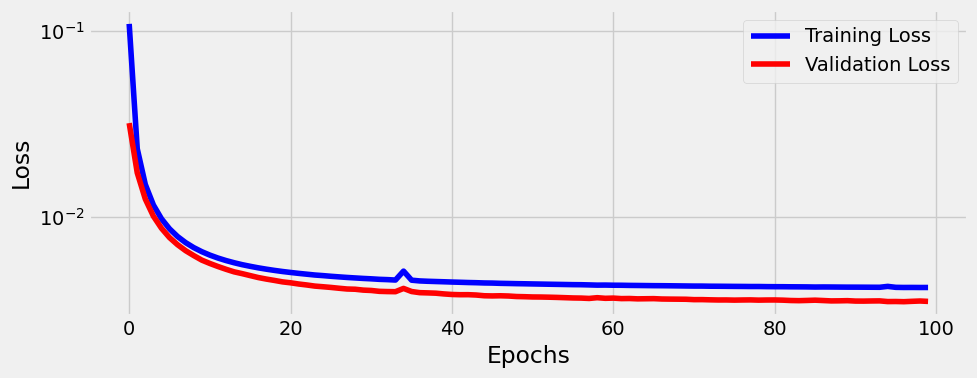

In [28]:
fig = arch.plot_losses()

In [30]:
fig.savefig('images/train_losses.png', dpi=300, bbox_inches='tight')

In [31]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0325, -0.0472, -0.0512,  0.5570,  0.0648, -0.0615, -0.0221, -0.2160,
                       -0.2424, -0.4272,  0.0403, -0.0951, -0.1866, -0.5564, -0.0802, -0.1896,
                       -0.0037,  0.0066,  0.0370, -0.0905,  0.1647,  0.1906, -0.0243,  0.0357,
                       -0.0414,  0.0211, -0.1090, -0.0181,  0.0294]], device='cuda:0')),
             ('linear.bias', tensor([-7.7153], device='cuda:0'))])

## Making predictions

### logits (z)

In [32]:
logits_val = arch.predict(X_val[:4])
logits_val

array([[-7.631151 ],
       [-6.8907866],
       [-9.08636  ],
       [-7.447423 ]], dtype=float32)

### Probabilities

In [33]:
prob_val = torch.sigmoid(torch.as_tensor(logits_val[:4]).float())
prob_val

tensor([[0.0005],
        [0.0010],
        [0.0001],
        [0.0006]])

In [34]:
classes = (prob_val >= 0.5).to(torch.int8)
classes

tensor([[0],
        [0],
        [0],
        [0]], dtype=torch.int8)

## Results

In [37]:
logits_val = arch.predict(X_val)
probabilities_val = list(map(lambda x: torch.sigmoid(torch.as_tensor(x).float()), logits_val))
threshold = 0.5

### Data visualization

Confusion Matrix:
[[56856     5]
 [   41    60]]


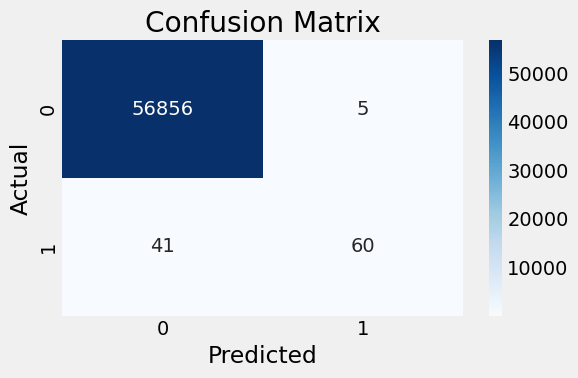

In [43]:
y_pred = (torch.stack(probabilities_val).numpy() >= threshold).astype(int)

cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(cm)

fig_cm, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.tight_layout()

plt.savefig('images/train_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

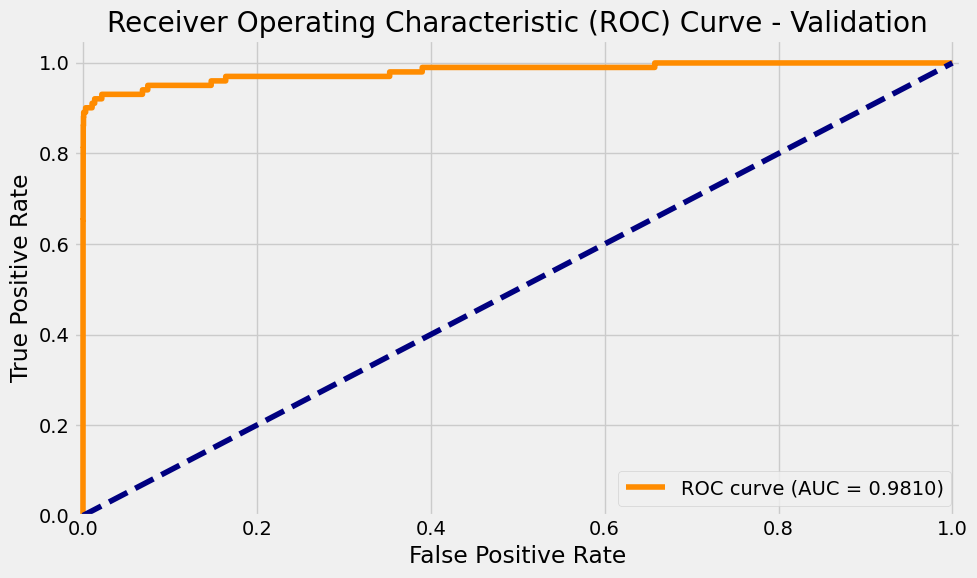

In [57]:
fpr, tpr, thresholds = roc_curve(y_val, [p.item() for p in probabilities_val])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Validation')
plt.legend(loc="lower right")
plt.tight_layout()

plt.savefig('images/train_val_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

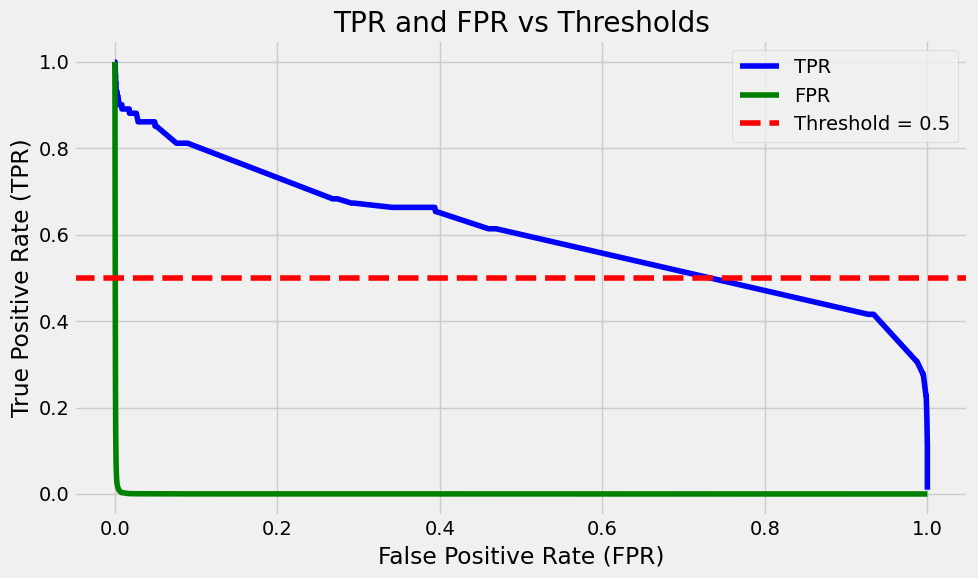

In [62]:
roc_auc = round(auc(fpr, tpr), 3)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, tpr, label='TPR', color='blue')
plt.plot(thresholds, fpr, label='FPR', color='green')
plt.axhline(y=0.5, color='red', linestyle='--', label='Threshold = 0.5')
# plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('TPR and FPR vs Thresholds')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('images/train_tpr_fpr_vs_thresholds.png', dpi=300, bbox_inches='tight')
plt.show()

In [75]:
rounded_thresholds = [round(value, 3) for value in set(thresholds)]
print("Rounded Thresholds: ", len(rounded_thresholds))

Rounded Thresholds:  1686


In [ ]:
results = []
for threshold in rounded_thresholds:
    y_val_pred = (probabilities_val >= threshold).astype(int)
    
    precision = precision_score(y_val, y_val_pred, zero_division=0)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    results.append((threshold, precision, recall, f1))

# Convertir lista a DataFrame
metrics_df = pd.DataFrame(results, columns=['threshold', 'precision', 'recall', 'f1-score'])
metrics_df.sort_values(by="f1-score", ascending=False, inplace=True)
print(metrics_df)

      threshold  precision    recall  f1-score
43        0.049   0.834951  0.851485  0.843137
36        0.049   0.834951  0.851485  0.843137
42        0.051   0.841584  0.841584  0.841584
41        0.076   0.845361  0.811881  0.828283
1179      0.090   0.852632  0.801980  0.826531
...         ...        ...       ...       ...
4         1.000   0.000000  0.000000  0.000000
582         inf   0.000000  0.000000  0.000000
2         1.000   0.000000  0.000000  0.000000
1         1.000   0.000000  0.000000  0.000000
0         1.000   0.000000  0.000000  0.000000

[1686 rows x 4 columns]


In [66]:
print(f'A threshold of {metrics_df.iloc[0]["threshold"]} seems to be the best one for this model')

A threshold of 0.049 seems to be the best one for this model


In [63]:
metrics_df.to_csv('images/train_metrics_per_threshold.csv', index=False)

### Metrics

In [67]:
from sklearn.metrics import roc_auc_score

In [69]:
val_roc_auc= round(roc_auc_score(y_val, y_pred),4)
print(f'The ROC AUC for the linear model is {val_roc_auc} on the validation dataset.')

The ROC AUC for the linear model is 0.797 on the validation dataset.


In [73]:
y_train_pred_proba = arch.predict(X_train)
train_roc_auc= round(roc_auc_score(y_train, y_train_pred_proba),3)
print(f'The ROC AUC for the linear model is {train_roc_auc} on the train dataset.')

The ROC AUC for the linear model is 0.98 on the train dataset.


In [65]:
print(classification_report(y_val, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.92      0.59      0.72       101

    accuracy                           1.00     56962
   macro avg       0.96      0.80      0.86     56962
weighted avg       1.00      1.00      1.00     56962

